# Experiment: Does removing the local response normalization layers from AlexNet improve performance?

This experiment follows from [2025-12-26-reproduce-alain-2016-understanding.ipynb](2025-12-26-reproduce-alain-2016-understanding.ipynb) where we saw that the local response normalization layers in AlexNet lead to worse linear separability. Hypothesis: Removing them will improve the classification accuracy of the model.

## Results summary

* Accuracy improves significantly faster when removing the local response normalization layers, but ultimately, it still converges to the same accuracy as the original model.
* The results are more complicated when using loss rather than accuracy as the metric.
  * Training loss is consistently better in the modified model.
  * Validation loss starts of being better and then gets worse than the original model after ~10 epochs of training.
  * If we ignore after how much training the minimum validation loss is achieved, the two models have approximately equal minimum validation loss.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device {DEVICE}')

Using device cuda


## Load and preprocess CIFAR-10 data

In [3]:
# Transformations for the training and test sets
class PerImageStandardize:
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        # x: Tensor [C, H, W] in float
        mean = x.mean()
        std = x.std().clamp_min(1.0 / (x.numel() ** 0.5))
        x = (x - mean) / std
        return x


transform_data = transforms.Compose([
    transforms.CenterCrop(28),
    transforms.ToTensor(),  # Changes shape from (height, width, channels) to (channels, height, width).
    PerImageStandardize(),
])

train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_data
)

test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_data
)

print(f"Number of training samples: {len(train_set)}")
print(f"Number of test samples: {len(test_set)}")

100%|██████████| 170M/170M [00:03<00:00, 47.6MB/s]


Number of training samples: 50000
Number of test samples: 10000


## Model: AlexNet

In [4]:
class AlexNet(nn.Module):
    name = 'alexnet'
    
    def __init__(self):
        super(AlexNet, self).__init__()

        self.conv_layers = nn.Sequential(
            
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),

            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),

            nn.Conv2d(128, 192, kernel_size=3, padding=1),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.Conv2d(192, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc_layers(x)
        return x

In [5]:
class AlexNetModified(nn.Module):
    name = 'alexnetmod'
    
    def __init__(self):
        super(AlexNetModified, self).__init__()

        self.conv_layers = nn.Sequential(
            
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(128, 192, kernel_size=3, padding=1),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.Conv2d(192, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc_layers(x)
        return x

## Training

In [6]:
def train_one_epoch(model, train_loader, loss_function, optimizer, scheduler):
    '''
    Handle a single training pass, including forward and backward propagation,
    loss calculation, gradient optimization, and accumulation of training metrics.
    '''
    # Set the model to training mode
    model.train()
    # Initialize metrics
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for inputs, labels in train_loader:
        # Load data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        # Update training loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    scheduler.step()
    # Return average metrics
    epoch_loss = running_loss / total_samples
    epoch_accuracy = 100 * correct_predictions / total_samples
    return epoch_loss, epoch_accuracy

In [7]:
def evaluate_model(model, data_loader, loss_function):
    '''
    Place the model in evaluation mode, disable gradient calculations,
    and compute average loss and accuracy on a given dataset.
    '''
    model.eval()  # Set the model to evaluation mode

    # Init metrics
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():  # Disable gradient calculations, i.e. freeze the model parameters
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            # Update metrics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / total_samples
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

In [8]:
def train_model(model, batch_size = 128, num_workers = 0, num_epochs = 100, save_state = True, overwrite = False):
    '''
    Setup data loaders, model, and optimizer. Then, orchestrate model training
    over multiple epochs, calling `train_one_epoch` and `evaluate_model` to
    track both training and validation performance.
    '''
    import torch.optim as optim
    from torch.optim.lr_scheduler import ExponentialLR
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    validation_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    model.to(DEVICE)
    print(f"Model moved to device: {DEVICE}")
    
    # Choose the loss function: cross-entropy loss for classification task
    loss_function = nn.CrossEntropyLoss()
    
    # Choose the optimizer, for example `Adam` or `SGD` with appropriate learning rate.
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = ExponentialLR(optimizer, gamma=0.95)
    
    def _save_state(epoch):
        nonlocal model, save_state, overwrite
        if not save_state:
            return
        path = f"{model.name}-epoch-{epoch:03d}.pt"
        try:
            open(path, 'r')
        except FileNotFoundError:
            pass
        else:
            if not overwrite:
                import errno
                raise FileExistsError(
                    errno.EEXIST,
                    "File already exists (and overwrite not allowed)",
                    path,
                )
        torch.save(model.state_dict(), path)

    _save_state(epoch=0)
    print("Starting training...")
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'validation_loss': [],
        'validation_accuracy': [],
    }
    try:
        for epoch in range(num_epochs):
            train_loss, train_accuracy = train_one_epoch(model, train_loader, loss_function, optimizer, scheduler)
            validation_loss, validation_accuracy = evaluate_model(model, validation_loader, loss_function)
            _save_state(epoch=epoch + 1)
            history['train_loss'].append(train_loss)
            history['train_accuracy'].append(train_accuracy)
            history['validation_loss'].append(validation_loss)
            history['validation_accuracy'].append(validation_accuracy)
            print(f"Completed epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%")
    except KeyboardInterrupt:
        print('Interrupted')

    print("Training finished.")
    return history

In [9]:
num_training_epochs = 30

model_original = AlexNet()
training_history_original = train_model(model_original, num_epochs=num_training_epochs, num_workers = 2, save_state=False)

model_modified = AlexNetModified()
training_history_modified = train_model(model_modified, num_epochs=num_training_epochs, num_workers = 2, save_state=False)

import pickle
with open('2026-01-07-train-and-compare-modified-alexnet/training-history.pickle', 'wb') as fp:
    pickle.dump(training_history_original, fp)
    pickle.dump(training_history_modified, fp)

Model moved to device: cuda
Starting training...
Completed epoch 1/30: Train Loss: 2.1585, Train Accuracy: 17.82%, Validation Loss: 1.8241, Validation Accuracy: 28.65%
Completed epoch 2/30: Train Loss: 1.6648, Train Accuracy: 37.09%, Validation Loss: 1.4783, Validation Accuracy: 45.13%
Completed epoch 3/30: Train Loss: 1.3522, Train Accuracy: 50.33%, Validation Loss: 1.2601, Validation Accuracy: 54.95%
Completed epoch 4/30: Train Loss: 1.1359, Train Accuracy: 58.85%, Validation Loss: 1.0527, Validation Accuracy: 62.78%
Completed epoch 5/30: Train Loss: 0.9742, Train Accuracy: 65.36%, Validation Loss: 0.9278, Validation Accuracy: 67.77%
Completed epoch 6/30: Train Loss: 0.8492, Train Accuracy: 70.12%, Validation Loss: 0.9135, Validation Accuracy: 68.57%
Completed epoch 7/30: Train Loss: 0.7597, Train Accuracy: 73.38%, Validation Loss: 0.8200, Validation Accuracy: 71.78%
Completed epoch 8/30: Train Loss: 0.6770, Train Accuracy: 76.25%, Validation Loss: 0.7665, Validation Accuracy: 73.34%

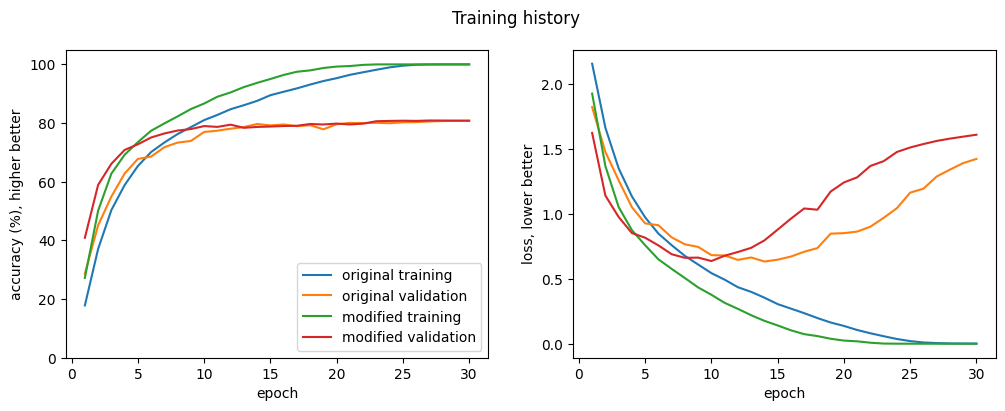

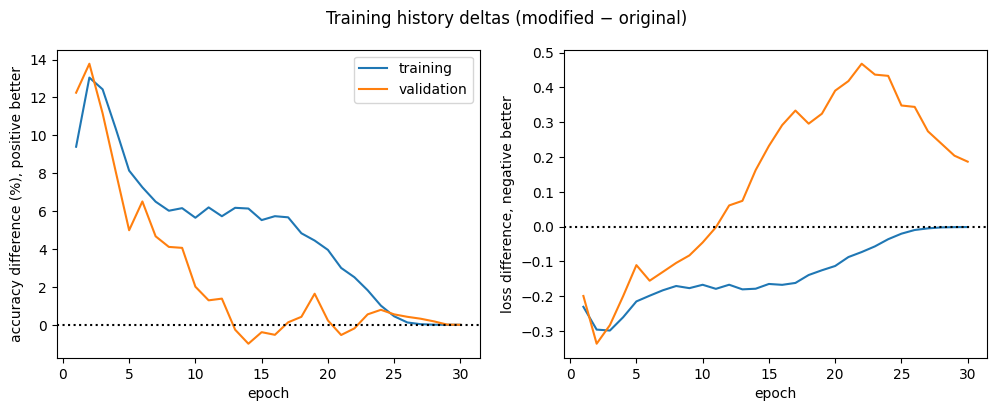

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

with open('2026-01-07-train-and-compare-modified-alexnet/training-history.pickle', 'rb') as fp:
    training_history_original = pickle.load(fp)
    training_history_modified = pickle.load(fp)

plt.figure(figsize=(12, 4))
plt.suptitle("Training history")
plt.subplot(1, 2, 1)
plt.xlabel("epoch")
plt.ylabel("accuracy (%), higher better")
epochs = list(range(1, len(training_history_original['train_accuracy']) + 1))
plt.plot(epochs, training_history_original['train_accuracy'], '-', label="original training")
plt.plot(epochs, training_history_original['validation_accuracy'], '-', label="original validation")
plt.plot(epochs, training_history_modified['train_accuracy'], '-', label="modified training")
plt.plot(epochs, training_history_modified['validation_accuracy'], '-', label="modified validation")
plt.ylim(0, 105)
plt.legend()
plt.subplot(1, 2, 2)
plt.xlabel("epoch")
plt.ylabel("loss, lower better")
epochs = list(range(1, len(training_history_original['train_accuracy']) + 1))
plt.plot(epochs, training_history_original['train_loss'], '-', label="original training")
plt.plot(epochs, training_history_original['validation_loss'], '-', label="original validation")
plt.plot(epochs, training_history_modified['train_loss'], '-', label="modified training")
plt.plot(epochs, training_history_modified['validation_loss'], '-', label="modified validation")

plt.figure(figsize=(12, 4))
plt.suptitle("Training history deltas (modified − original)")
plt.subplot(1, 2, 1)
plt.xlabel("epoch")
plt.ylabel("accuracy difference (%), positive better")
plt.plot(
    epochs,
    np.array(training_history_modified['train_accuracy']) - np.array(training_history_original['train_accuracy']),
    '-', label="training")
plt.plot(
    epochs,
    np.array(training_history_modified['validation_accuracy']) - np.array(training_history_original['validation_accuracy']),
    '-', label="validation")
plt.axhline(0, linestyle=':', color='k')
plt.legend()
plt.subplot(1, 2, 2)
plt.xlabel("epoch")
plt.ylabel("loss difference, negative better")
plt.plot(
    epochs,
    np.array(training_history_modified['train_loss']) - np.array(training_history_original['train_loss']),
    '-', label="training")
plt.plot(
    epochs,
    np.array(training_history_modified['validation_loss']) - np.array(training_history_original['validation_loss']),
    '-', label="validation")
plt.axhline(0, linestyle=':', color='k')

plt.show()